#### パーセプトロンの学習
静的離散時間モデルの機能を理解するために、前々項で触れたパーセプトロンおよびその学習則について紹介する。再掲になるが、出力が1つの現代的なパーセプトロンでは、$n$ 個のシナプス前細胞の活動をベクトル $\mathbf{x} = [x_1, x_2, \dots, x_n]^\top \in \mathbb{R}^n$、シナプス重みを $\mathbf{w} = [w_1, w_2, \dots, w_n]^\top \in \mathbb{R}^n$、定常項（バイアス項）を $b \in \mathbb{R}$、シナプス後細胞の出力を $y \in \mathbb{R}$ とすると、

$$
y = f(\mathbf{w}^\top \mathbf{x} + b) = f\left(\sum_{i=1}^n w_i x_i + b\right)
$$

となる。データセット $\mathcal{D}=\{\mathbf{x}_{(i)}, y^*_{(i)}\}_{i=1}^N$ が与えられているとき、モデルは入力 $\mathbf{x}_{(i)}$ に対して対応する出力 $y^*_{(i)}$ を生成するように学習される。ここで、$y^*$ は望ましい出力（教師信号）、$y$ はモデルが出力した推定値である。

活性化関数 $f(\cdot)$ には Heaviside の階段関数 $H(\cdot)$ を用いる \footnote{符号関数 $\mathrm{sgn}(\cdot)$ を用いる場合は$y, y^* \in \{\pm 1\}$ となる．Heaviside の階段関数を用いる場合に比べて，誤差の大きさが2倍になる $(|1-(-1)|/|1-0|=2)$ ため，学習率 $\eta$ に $\frac{1}{2}$ を掛ければ同等の学習則となる}．この場合，出力と教師信号の値域は $y, y^* \in \{0, 1\}$ となる．重みの更新則は次のように表される：

$$
\begin{align}
y &= f(\mathbf{w}^\top \mathbf{x} + b) \\
\varepsilon &= y^* - y \\
\Delta \mathbf{w} &= \eta \varepsilon \mathbf{x} \\
\Delta b &= \eta \varepsilon
\end{align}
$$

ここで、$\delta$ は誤差信号を表す。

パーセプトロンの学習則は、誤りを訂正するという直感に基づいて導出される。入力がベクトル $\mathbf{x} \in \mathbb{R}^n$、出力が $\hat{y} = \mathrm{sgn}(\mathbf{w}^\top \mathbf{x} + b)$、教師信号が $y \in \{-1, +1\}$ の2値分類問題を考える。ここでの目的は、入力 $\mathbf{x}$ に対して出力 $\hat{y}$ が教師信号 $y$ に一致するように重み $\mathbf{w}$ およびバイアス $b$ を調整することである。

パーセプトロンでは、予測が正しかった場合、すなわち $\hat{y} = y$ のときには重みの更新を行わない。一方で、予測が誤っていた場合、すなわち $\hat{y} \ne y$ のときには、その誤りを訂正する方向に重みを更新する。たとえば、本来のラベルが $y = +1$ であるにもかかわらず出力が $\hat{y} = -1$ であった場合、現在の重みベクトルは入力ベクトルに反対方向の反応を示していることになる。したがって、このときは重みベクトルを入力ベクトルの方向に動かす必要がある。逆に、本来のラベルが $y = -1$ にもかかわらず $\hat{y} = +1$ と予測された場合には、重みベクトルを入力ベクトルの逆方向に動かす必要がある。

このように、分類誤りが生じたときに、重みベクトルを $y\mathbf{x}$ の方向へ調整するという規則を設けることで、学習が進行する。この重みの更新は、学習率 $\eta > 0$ を用いて次のように表される：

$$
\Delta \mathbf{w} = \eta y \mathbf{x}, \quad \Delta b = \eta y
$$

この更新則は分類誤りが生じたときにのみ適用される。一方で、すべての入力に対して同一の形式で書くためには、誤差信号 $\delta = y - \hat{y}$ を導入し、

$$
\Delta \mathbf{w} = \eta \delta \mathbf{x}, \quad \Delta b = \eta \delta
$$

と表すこともできる。ただし、$\hat{y} \in \{-1, +1\} $ の場合、正解時には $\delta = 0$ となるため、結局誤った予測に対してのみ重みが更新されるという性質は保たれる。このようにして、活性化関数の微分や連続性に依存せず、幾何的な直観に基づく単純なルールとして、パーセプトロンの学習則は定式化される。


In [1]:
using Random, PyPlot, ProgressMeter
rc("axes.spines", top=false, right=false)

In [2]:
N = 400 # num of inputs
dims = 2  # dims of inputs 
Random.seed!(0)
X = [randn(Int(N/2), dims);  3.0 .+ randn(Int(N/2), dims)];
y = [zeros(Int(N/2), 1); ones(Int(N/2), 1)];

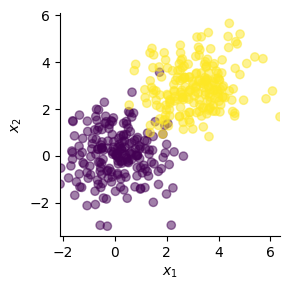

In [3]:
fig, ax = subplots(figsize=(3, 3))
ax.scatter(X[:, 1], X[:, 2], c=y, alpha=0.5)
ax.set_xlabel(L"$x_1$"); ax.set_ylabel(L"$x_2$"); 
ax.set_xlim(extrema(X[:, 1])...)
tight_layout()

In [4]:
step(x) = 1.0(x > 0)

function perceptron(X, y_true; init_W=nothing, init_b=nothing, lr=0.1, num_iters=100)
    num_samples, n = size(X)
    m = size(y_true)[2]

    # initial weights and func
    scale = 1 / sqrt(n)
    W = init_W !== nothing ? init_W : scale * randn(n, m)
    b = init_b !== nothing ? init_b : scale * randn(m)

    # save array
    loss = zeros(num_iters);
    lr /= num_samples
    for t in 1:num_iters
        y_pred = step.(X * W .+ b)
        e = y_true - y_pred
        loss[t] = sum(e.^2) 
        W[:, :] .+= lr * X' * e
        b[:] .+= lr * sum(e)
    end
    return W, b, loss
end

perceptron (generic function with 1 method)

In [5]:
num_samples, n = size(X)
lr = 0.1
scale = 1 / sqrt(n)
Random.seed!(1234)
init_W = scale * randn(n, 1)
init_b = scale * randn(1)
W, b, loss = perceptron(X, y, init_W=init_W, init_b=init_b, lr=lr, num_iters=100);

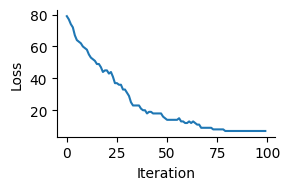

In [6]:
figure(figsize=(3,2))
plot(loss)
xlabel("Iteration"); ylabel("Loss")
tight_layout()

In [7]:
y_pred = step.(X * W .+ b); # predictio n

xx = range(extrema(X[:, 1])...; step=0.01)
yy = -(W[1]*xx .+ b) / W[2];

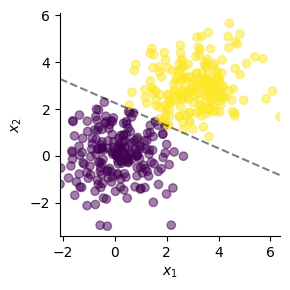

In [8]:
fig, ax = subplots(figsize=(3, 3))
ax.scatter(X[:, 1], X[:, 2], c=y_pred, alpha=0.5)
ax.plot(xx, yy, color="k", linestyle="dashed", alpha=0.5)
ax.set_xlabel(L"$x_1$"); ax.set_ylabel(L"$x_2$"); 
ax.set_xlim(extrema(X[:, 1])...)
tight_layout()

ここで，$\eta > 0$ は学習率，$y^{(i)}$ は正解ラベルである．この更新則により，パーセプトロンは誤分類を修正する方向に重みを調整する．

もし訓練データが**線形分離可能**であるならば，このアルゴリズムは有限回の更新で必ず収束する（**パーセプトロン収束定理**）．ただし，データが線形分離不可能な場合は，収束せずに振動を続けることがある．

本項では，機能的な離散モデルの例としてパーセプトロンの学習を扱った．学習則の導出は分類誤りに対して重みベクトルを修正する，という単純なものである．本項で扱ったパーセプトロンは微分不可能な関数を活性化関数に持つため，最適化の概念から学習則を記述することは線形回帰モデルやロジスティック回帰モデルなどに比べると難しい．しかし，現代的に**直通推定量** (Straight-Through Estimator; STE) と呼ばれる概念を導入することで導出することは可能である．STEに関してはここでは深く触れず，第7章で改めて紹介を行う．

https://www.cs.utexas.edu/~gdurrett/courses/fa2022/perc-lr-connections.pdf

<https://en.wikipedia.org/wiki/Perceptron>

<https://arxiv.org/abs/2012.03642>


perceptronは0/1 or -1/1のどちらか

UNDERSTANDING STRAIGHT-THROUGH ESTIMATOR IN TRAINING ACTIVATION QUANTIZED NEURAL NETS

Yoshua Bengio, Nicholas L´eonard, and Aaron Courville. Estimating or propagating gradients through stochastic neurons for conditional computation. arXiv preprint arXiv:1308.3432, 2013.

Hinton (2012) in his lecture 15b

G. Hinton. Neural networks for machine learning, 2012.
<https://www.cs.toronto.edu/~hinton/coursera_lectures.html>

delta rule